# Initialization

Automatically search for an NVIDIA GPU and use it. If not, then use CPU

In [1]:
import torch


if torch.cuda.is_available():
    device = torch.device('cuda')
    print('Using GPU')
else:
    device = 'cpu'
    print('Using CPU')

Using GPU


Load all of our preprocessed and split data from our cache

In [2]:
import pickle


with open('../preprocessing/feature_dimensions.pkl', 'rb') as file_handle:
    orig_atom_fea_len, nbr_fea_len = pickle.load(file_handle)

with open('../preprocessing/splits.pkl', 'rb') as file_handle:
    splits = pickle.load(file_handle)

sdts_train, sdts_val = splits['sdts_train'], splits['sdts_val']
targets_train, targets_val = splits['targets_train'], splits['targets_val']

Initialize the CGCNN `net` class

In [3]:
from torch.optim import Adam
import skorch.callbacks.base
from skorch import callbacks  # needs skorch >= 0.4  
from skorch import NeuralNetRegressor
from skorch.dataset import CVSplit
from cgcnn.model import CrystalGraphConvNet
from cgcnn.data import collate_pool, MergeDataset


# Callback to checkpoint parameters every time there is a new best for validation loss
cp = callbacks.Checkpoint(monitor='valid_loss_best', fn_prefix='valid_best_')

# Callback to load the checkpoint with the best validation loss at the end of training
class train_end_load_best_valid_loss(callbacks.base.Callback):
    def on_train_end(self, net, X, y):
        net.load_params('valid_best_params.pt')
load_best_valid_loss = train_end_load_best_valid_loss()

# Callback to set the learning rate dynamically
LR_schedule = callbacks.lr_scheduler.LRScheduler('MultiStepLR', milestones=[100], gamma=0.1)

net = NeuralNetRegressor(
    CrystalGraphConvNet,
    module__orig_atom_fea_len=orig_atom_fea_len,
    module__nbr_fea_len=nbr_fea_len,
    batch_size=214,
    module__classification=False,
    lr=0.0056,
    max_epochs=150,
    module__atom_fea_len=46,
    module__h_fea_len=83,
    module__n_conv=8,
    module__n_h=4,
    optimizer=Adam,
    iterator_train__pin_memory=True,
    iterator_train__num_workers=0,
    iterator_train__collate_fn=collate_pool,
    iterator_train__shuffle=True,
    iterator_valid__pin_memory=True,
    iterator_valid__num_workers=0,
    iterator_valid__collate_fn=collate_pool,
    iterator_valid__shuffle=False,
    device=device,
    criterion=torch.nn.L1Loss,
    dataset=MergeDataset,
    callbacks=[cp, load_best_valid_loss, LR_schedule]
)

# Training

We can train a new model...

In [4]:
net.initialize()
net.fit(sdts_train, targets_train)

Re-initializing module because the following parameters were re-set: atom_fea_len, classification, h_fea_len, n_conv, n_h, nbr_fea_len, orig_atom_fea_len.
Re-initializing optimizer.
  epoch    train_loss    valid_loss    cp      dur
-------  ------------  ------------  ----  -------
      1        0.4956        0.3552     +  20.9598
      2        0.2969        0.2818     +  20.4735
      3        0.3151        0.3494        20.5017
      4        0.2619        0.2668     +  20.5241
      5        0.2664        0.2083     +  20.4595
      6        0.2546        0.2397        20.4404
      7        0.2371        0.2144        20.5406
      8        0.2411        0.3480        20.4875
      9        0.2045        0.2701        20.5055
     10        0.2262        0.2185        20.7122
     11        0.2353        0.2100        20.5174
     12        0.2388        0.2714        20.4445
     13        0.2264        0.2069     +  20.4335
     14        0.2291        0.2397        20.4468
  

<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=CrystalGraphConvNet(
    (embedding): Linear(in_features=98, out_features=46, bias=True)
    (convs): ModuleList(
      (0): ConvLayer(
        (fc_full): Linear(in_features=98, out_features=92, bias=True)
        (sigmoid): Sigmoid()
        (softplus1): Softplus(beta=1, threshold=20)
        (bn1): BatchNorm1d(92, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn2): BatchNorm1d(46, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (softplus2): Softplus(beta=1, threshold=20)
      )
      (1): ConvLayer(
        (fc_full): Linear(in_features=98, out_features=92, bias=True)
        (sigmoid): Sigmoid()
        (softplus1): Softplus(beta=1, threshold=20)
        (bn1): BatchNorm1d(92, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn2): BatchNorm1d(46, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (softplus2): Softplus(

...or load whatever is cached

In [4]:
net.initialize()
net.load_params(f_history='valid_best_history.json',
                f_optimizer= 'valid_best_optimizer.pt', 
                f_params='valid_best_params.pt')

# Assess performance

MAE = 0.17 eV
RMSE = 0.33 eV
R^2 = 0.76


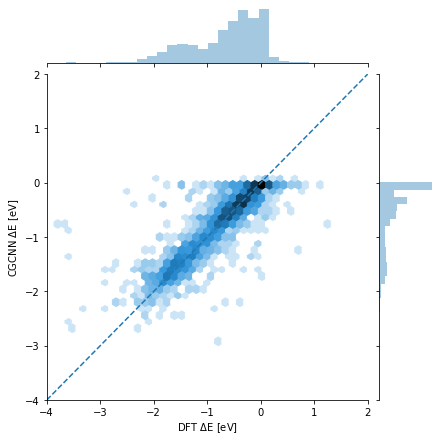

In [5]:
%matplotlib inline
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import seaborn as sns


# Calculate the error metrics
targets_pred = net.predict(sdts_val).reshape(-1)
mae = mean_absolute_error(targets_val, targets_pred)
rmse = np.sqrt(mean_squared_error(targets_val, targets_pred))
r2 = r2_score(targets_val, targets_pred)

# Report
print('MAE = %.2f eV' % mae)
print('RMSE = %.2f eV' % rmse)
print('R^2 = %.2f' % r2)

# Plot
lims = [-4, 2]
grid = sns.jointplot(targets_val.reshape(-1), targets_pred,
                     kind='hex',
                     bins='log',
                     extent=lims+lims)
_ = grid.ax_joint.set_xlim(lims)
_ = grid.ax_joint.set_ylim(lims)
_ = grid.ax_joint.plot(lims, lims, '--')
_ = grid.ax_joint.set_xlabel('DFT $\Delta$E [eV]')
_ = grid.ax_joint.set_ylabel('CGCNN $\Delta$E [eV]')